# Razonamiento de obtención de parámetros

### Ancho de haz

Para esto simplemente se mide el angulo de apertura entre el punto de máxima directividad y los puntos donde la magnitud cae 3dB. Como los datos estan en dB normalizados el punto de máx directividad es a 0dB

### Relación axial

Se define como $AR = \frac{\text{major axis}}{\text{minor axis}}$. Los datos medidos con el AE están en dBm con lo cual simplemente restar un valor (se elige el de máxima directividad) de la polarización cruzada al mismo punto en polarización directa da la relación axial en dB

### Directividad

Esto me quedó dudoso porque estoy midiendo en un solo plano con lo cual no es realmente contra una antena isotrópica lo que estoy midiendo. No pongo en la entrega

Se define como $\frac{U}{U_0}$. Para calcularla paso los datos de dBm a watts lineales así evito distorsión y calculo el promedio. Luego la distancia del máximo al promedio es la directividad

- Linealizo: $\displaystyle P_i = 10^{(P_i - 30) / 10}$

- Promedio: $\displaystyle P_{prom} = \frac 1 N \sum_i P_i$

- Calculo patron relativo: $\displaystyle P_{rel} = \frac{P_i}{P_{prom}}$

- Calculo directividad: $D = \displaystyle \text{max}(P_{rel})$

- Y paso a dB: $\displaystyle D(\text{dB}) = 10\cdot \log_{10}(D)$

In [4]:
from scripts.sa_data import SAData, load_sa_data
import matplotlib.pyplot as plt
import numpy as np

In [2]:
directa_medida_27 = load_sa_data('./mediciones/directa_2.7GHz.DAT')
directa_medida_29 = load_sa_data('./mediciones/directa_2.9GHz.DAT')
directa_medida_31 = load_sa_data('./mediciones/directa_3.1GHz.DAT')

cruzada_medida_27 = load_sa_data('./mediciones/cruzada_2.7GHz.DAT')
cruzada_medida_29 = load_sa_data('./mediciones/cruzada_2.9GHz.DAT')
cruzada_medida_31 = load_sa_data('./mediciones/cruzada_3.1GHz.DAT')

directa_simulada_27 = load_sa_data('./simulaciones/directa_2.7GHz.DAT')
directa_simulada_29 = load_sa_data('./simulaciones/directa_2.9GHz.DAT')
directa_simulada_31 = load_sa_data('./simulaciones/directa_3.1GHz.DAT')

cruzada_simulada_27 = load_sa_data('./simulaciones/cruzada_2.7GHz.DAT')
cruzada_simulada_29 = load_sa_data('./simulaciones/cruzada_2.9GHz.DAT')
cruzada_simulada_31 = load_sa_data('./simulaciones/cruzada_3.1GHz.DAT')

# Ancho de haz

## Ancho de haz en mediciones

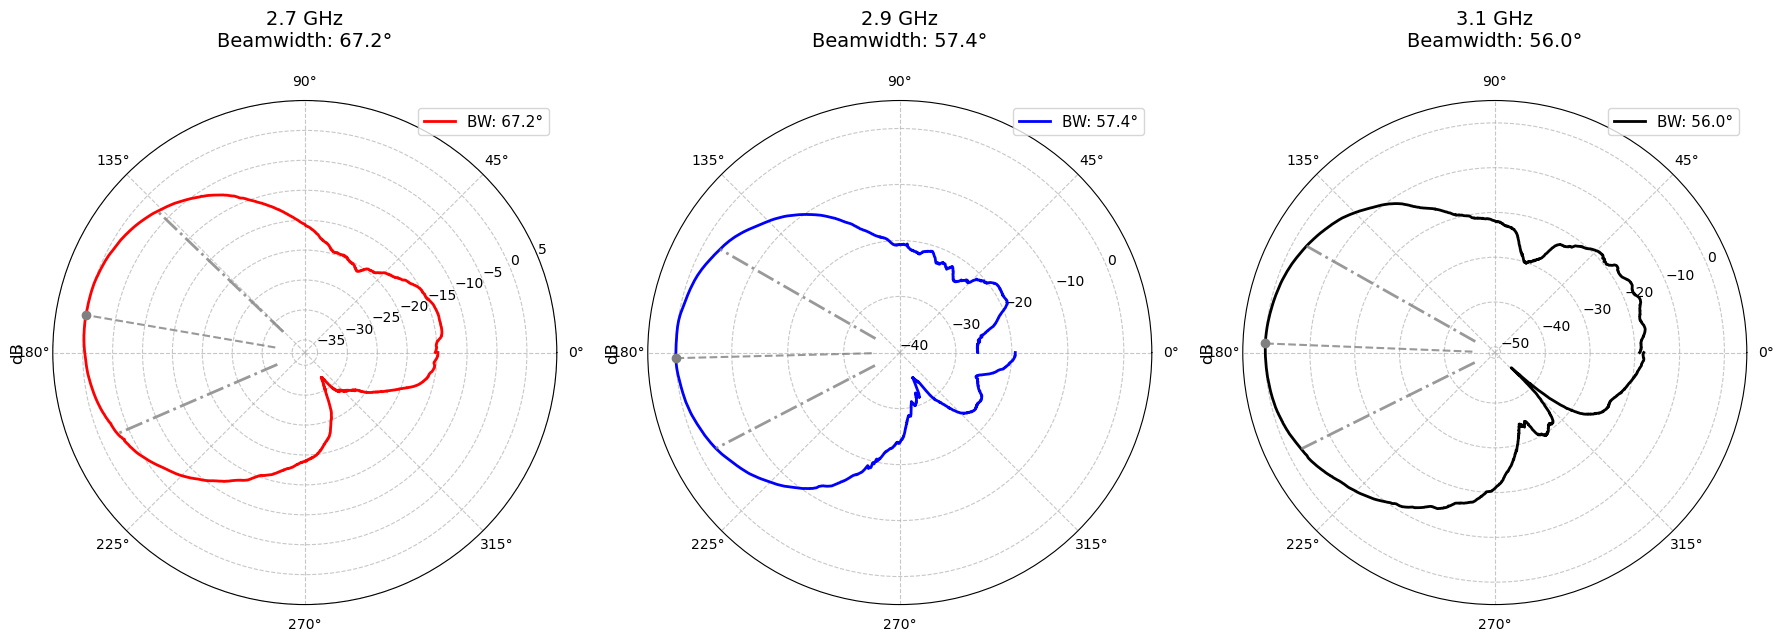

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Configuración de colores y estilos para cada frecuencia
frecuencias = [
    (directa_medida_27, '2.7 GHz', 'red'),
    (directa_medida_29, '2.9 GHz', 'blue'),
    (directa_medida_31, '3.1 GHz', 'black')
]

# Crear figura con 3 subplots polares uno al lado del otro
fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                        subplot_kw={'projection': 'polar'})

# Procesar cada medición en su propio subplot
for i, (medicion, frecuencia, color) in enumerate(frecuencias):
    ax = axes[i]

    # Obtener datos
    magnitude_data = medicion.convert_to_db()
    angle_data = medicion.convert_to_polar()

    # Encontrar punto de máxima directividad
    max_idx = np.argmax(magnitude_data)
    max_angle = angle_data[max_idx]
    max_directivity = magnitude_data[max_idx]

    # Calcular beamwidth
    beamwidth_threshold = max_directivity - 3.0
    beamwidth_indices = np.where(magnitude_data >= beamwidth_threshold)[0]

    if len(beamwidth_indices) > 0:
        first_beam_idx = beamwidth_indices[0]
        last_beam_idx = beamwidth_indices[-1]
        beamwidth_angle = abs(angle_data[last_beam_idx] - angle_data[first_beam_idx])
        beamwidth_angle_deg = np.rad2deg(beamwidth_angle)
    else:
        beamwidth_angle_deg = 360.0
        first_beam_idx = 0
        last_beam_idx = len(angle_data) - 1

    # Obtener el valor mínimo dB para usar como "centro" del patrón
    min_db = np.min(magnitude_data)

    # Plotear el patrón de directividad (línea sólida con color de frecuencia)
    ax.plot(angle_data, magnitude_data, linewidth=2, color=color,
           label=f'BW: {beamwidth_angle_deg:.1f}°')

    # Marcar punto de máxima directividad (puntos grises)
    ax.plot([max_angle], [max_directivity], 'o', markersize=6, color='gray')

    # Dibujar línea de máxima directividad (punteada gris)
    ax.plot([max_angle, max_angle], [min_db, max_directivity],
           '--', linewidth=1.5, color='gray', alpha=0.8)

    # Dibujar líneas de beamwidth (punteada más gruesa gris)
    if len(beamwidth_indices) > 0:
        ax.plot([angle_data[first_beam_idx], angle_data[first_beam_idx]],
               [min_db, magnitude_data[first_beam_idx]],
               '-.', linewidth=2, color='gray', alpha=0.8)
        ax.plot([angle_data[last_beam_idx], angle_data[last_beam_idx]],
               [min_db, magnitude_data[last_beam_idx]],
               '-.', linewidth=2, color='gray', alpha=0.8)

    # Configurar cada subplot
    ax.set_title(f'{frecuencia}\nBeamwidth: {beamwidth_angle_deg:.1f}°',
                fontsize=14, pad=20)
    ax.set_ylabel('dB', fontsize=12, labelpad=20)

    # Configurar ángulos en grados
    ax.set_thetagrids(range(0, 360, 45),
                     ['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])

    # Configurar límites radiales para cada subplot
    ax.set_rlim(min_db - 5, max_db + 5)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_rlabel_position(22.5)

    # Añadir leyenda individual para cada subplot
    ax.legend(loc='upper right', fontsize=11)
    plt.savefig('./ploteos/beamwidth_medido.png', dpi=300)

# Ajustar el layout general
plt.tight_layout()
plt.show()

## Ancho de haz en simulaciones

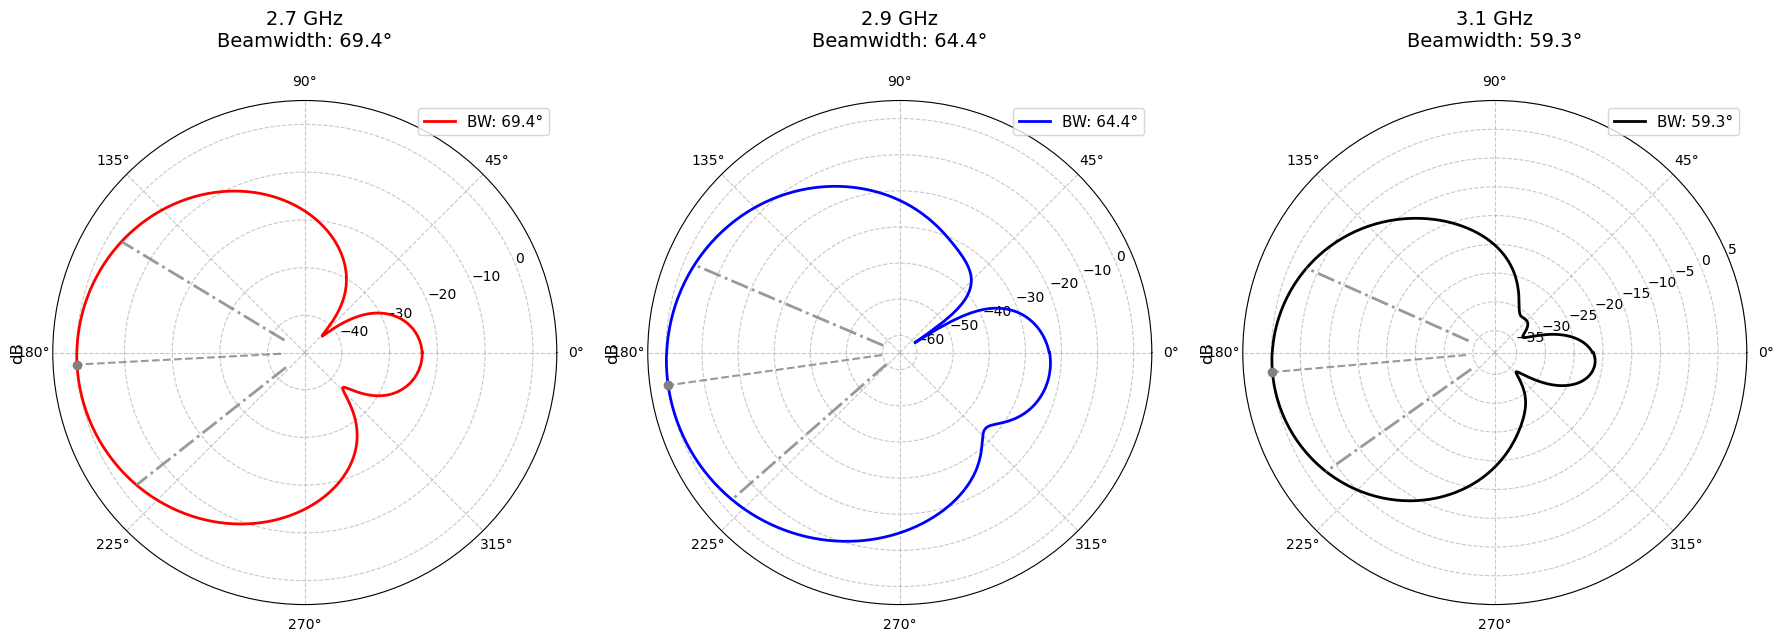

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Configuración de colores y estilos para cada frecuencia
frecuencias = [
    (directa_simulada_27, '2.7 GHz', 'red'),
    (directa_simulada_29, '2.9 GHz', 'blue'),
    (directa_simulada_31, '3.1 GHz', 'black')
]

# Crear figura con 3 subplots polares uno al lado del otro
fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                        subplot_kw={'projection': 'polar'})

# Procesar cada medición en su propio subplot
for i, (medicion, frecuencia, color) in enumerate(frecuencias):
    ax = axes[i]

    # Obtener datos
    magnitude_data = medicion.convert_to_db()
    angle_data = medicion.convert_to_polar()

    # Encontrar punto de máxima directividad
    max_idx = np.argmax(magnitude_data)
    max_angle = angle_data[max_idx]
    max_directivity = magnitude_data[max_idx]

    # Calcular beamwidth
    beamwidth_threshold = max_directivity - 3.0
    beamwidth_indices = np.where(magnitude_data >= beamwidth_threshold)[0]

    if len(beamwidth_indices) > 0:
        first_beam_idx = beamwidth_indices[0]
        last_beam_idx = beamwidth_indices[-1]
        beamwidth_angle = abs(angle_data[last_beam_idx] - angle_data[first_beam_idx])
        beamwidth_angle_deg = np.rad2deg(beamwidth_angle)
    else:
        beamwidth_angle_deg = 360.0
        first_beam_idx = 0
        last_beam_idx = len(angle_data) - 1

    # Obtener el valor mínimo dB para usar como "centro" del patrón
    min_db = np.min(magnitude_data)

    # Plotear el patrón de directividad (línea sólida con color de frecuencia)
    ax.plot(angle_data, magnitude_data, linewidth=2, color=color,
           label=f'BW: {beamwidth_angle_deg:.1f}°')

    # Marcar punto de máxima directividad (puntos grises)
    ax.plot([max_angle], [max_directivity], 'o', markersize=6, color='gray')

    # Dibujar línea de máxima directividad (punteada gris)
    ax.plot([max_angle, max_angle], [min_db, max_directivity],
           '--', linewidth=1.5, color='gray', alpha=0.8)

    # Dibujar líneas de beamwidth (punteada más gruesa gris)
    if len(beamwidth_indices) > 0:
        ax.plot([angle_data[first_beam_idx], angle_data[first_beam_idx]],
               [min_db, magnitude_data[first_beam_idx]],
               '-.', linewidth=2, color='gray', alpha=0.8)
        ax.plot([angle_data[last_beam_idx], angle_data[last_beam_idx]],
               [min_db, magnitude_data[last_beam_idx]],
               '-.', linewidth=2, color='gray', alpha=0.8)

    # Configurar cada subplot
    ax.set_title(f'{frecuencia}\nBeamwidth: {beamwidth_angle_deg:.1f}°',
                fontsize=14, pad=20)
    ax.set_ylabel('dB', fontsize=12, labelpad=20)

    # Configurar ángulos en grados
    ax.set_thetagrids(range(0, 360, 45),
                     ['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])

    # Configurar límites radiales para cada subplot
    ax.set_rlim(min_db - 5, max_db + 5)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_rlabel_position(22.5)

    # Añadir leyenda individual para cada subplot
    ax.legend(loc='upper right', fontsize=11)
    plt.savefig('./ploteos/beamwidth_simulada.png', dpi=300)

# Ajustar el layout general
plt.tight_layout()
plt.show()

# Relación axial

In [53]:
# Cálculo de Relación Axial para todas las frecuencias
print("=== Cálculo de Relación Axial ===")
print("Relación Axial = max_directa - cruzada_en_misma_posicion (en dB)")

# Frecuencias medidas
for freq in ['27', '29', '31']:
    directa = globals()[f'directa_medida_{freq}']
    cruzada = globals()[f'cruzada_medida_{freq}']

    # Obtener datos completos
    y_directa = directa.get_y1_data()
    y_cruzada = cruzada.get_y1_data()
    x_directa = directa.get_x_data()
    x_cruzada = cruzada.get_x_data()

    # 1. Encontrar posición del máximo en directa
    max_idx_directa = np.argmax(y_directa)
    max_directa = y_directa[max_idx_directa]
    pos_max_directa = x_directa[max_idx_directa]

    # 2. Encontrar valor en cruzada en la misma posición
    # Buscar el índice más cercano en cruzada a la posición del máximo en directa
    idx_cruzada = np.argmin(np.abs(x_cruzada - pos_max_directa))
    cruzada_en_misma_pos = y_cruzada[idx_cruzada]

    # 3. Calcular relación axial
    relacion_axial = max_directa - cruzada_en_misma_pos

    print(f"{freq[0]+'.'+freq[1]} GHz: {relacion_axial:.2f} dB")
    print(f"  - Directa: {max_directa:.2f} dBm en posición {pos_max_directa:.3f}")
    print(f"  - Cruzada: {cruzada_en_misma_pos:.2f} dBm en misma posición")

=== Cálculo de Relación Axial ===
Relación Axial = max_directa - cruzada_en_misma_posicion (en dB)
2.7 GHz: 18.27 dB
  - Directa: -33.07 dBm en posición 46.407
  - Cruzada: -51.34 dBm en misma posición
2.9 GHz: 16.33 dB
  - Directa: -34.32 dBm en posición 47.880
  - Cruzada: -50.65 dBm en misma posición
3.1 GHz: 15.72 dB
  - Directa: -35.79 dBm en posición 46.597
  - Cruzada: -51.50 dBm en misma posición


In [10]:
y_directa = directa_medida_27.get_y1_data()

In [11]:
np.max(y_directa)

np.float64(-33.06644821166992)

Para la simulada la extraigo del documento .txt usando el punto máximo en polarización directa y extrayendo la rel. axial para ese valor manualmente (viene especificado)

In [9]:
# Cálculo de Relación Axial para todas las frecuencias
print("=== Cálculo de Relación Axial ===")
print("Valores máximos de parámetros simulados")

# Frecuencias simuladas
print("\n--- Simulaciones ---")
for freq in ['27', '29', '31']:
    directa = globals()[f'directa_simulada_{freq}']

    y_directa = directa.get_y1_data()

    max_directa = np.max(y_directa)
    print(f"  - Valor máximo directa a {freq[0]+'.'+freq[1]}: {max_directa:.5f}")

=== Cálculo de Relación Axial ===
Valores máximos de parámetros simulados

--- Simulaciones ---
  - Valor máximo directa a 2.7: 7.48500
  - Valor máximo directa a 2.9: 8.61700
  - Valor máximo directa a 3.1: 8.53900


Buscando en los archivos txt tengo:
- $2.7\text{GHz}: 27.8$
- $2.9\text{GHz}: 26.27$
- $3.1\text{GHz}: 22.0$

## Directividad

In [49]:
# Cálculo de Directividad para mediciones directas
print("=== Cálculo de Directividad para Mediciones Directas ===")

# Frecuencias a procesar
frecuencias = [
    ('2.7 GHz', directa_medida_27),
    ('2.9 GHz', directa_medida_29),
    ('3.1 GHz', directa_medida_31)
]

for nombre, medicion in frecuencias:
    print(f"\n--- {nombre} ---")

    # Obtener datos en dBm
    P_dBm = medicion.get_y1_data()

    # 1. Linealizar: P_i = 10^((P_i_dBm - 30) / 10)
    P_linear = 10**((P_dBm - 30) / 10)

    # 2. Promedio: P_prom = (1/N) * Σ P_i
    P_prom = np.mean(P_linear)

    # 3. Patrón relativo: P_rel = P_i / P_prom
    P_rel = P_linear / P_prom

    # 4. Directividad: D = max(P_rel)
    D_linear = np.max(P_rel)

    # 5. Conversión a dB: D_dB = 10 * log10(D_linear)
    D_dB = 10 * np.log10(D_linear)

    # Mostrar resultados
    print(f"Directividad: {D_dB:.2f} dB")
    print(f"Potencia máxima: {np.max(P_dBm):.2f} dBm")
    print(f"Potencia promedio: {10 * np.log10(P_prom) + 30:.2f} dBm")

=== Cálculo de Directividad para Mediciones Directas ===

--- 2.7 GHz ---
Directividad: 6.83 dB
Potencia máxima: -33.07 dBm
Potencia promedio: -39.90 dBm

--- 2.9 GHz ---
Directividad: 7.56 dB
Potencia máxima: -34.32 dBm
Potencia promedio: -41.88 dBm

--- 3.1 GHz ---
Directividad: 7.59 dB
Potencia máxima: -35.79 dBm
Potencia promedio: -43.38 dBm
